## Hands on! 

In [5]:
import requests
import pandas as pd
from datetime import datetime

class MeteoClient:
    def __init__(self, location_code, api_url="https://api.meteo.lt/v1/"):
        """
        Inicializuoja klientą.
        :param location_code: Vietovės kodas, pvz., 'vilnius'.
        :param api_url: API URL adresas, numatytasis yra https://api.meteo.lt/v1/
        """
        self.location_code = location_code
        self.api_url = api_url

    def get_forecast_data(self):
        """
        Gauna prognozės duomenis.
        :return: pandas DataFrame su duomenimis ir pd.DatetimeIndex indeksu.
        """
        url = f"{self.api_url}places/{self.location_code}/forecasts/long-term"
        response = requests.get(url)
        response.raise_for_status()

        data = response.json().get("forecastTimestamps", [])
        df = pd.DataFrame(data)
        df['forecastTimeUtc'] = pd.to_datetime(df['forecastTimeUtc'])
        df = df.set_index('forecastTimeUtc')

        return df

# Naudojimas:
if __name__ == "__main__":
    location_code = "vilnius"
    client = MeteoClient(location_code)

    # Prognozės duomenų gavimas
    forecast_df = client.get_forecast_data()
    print("\nPrognozės duomenys:")
    print(forecast_df)



Prognozės duomenys:
                     airTemperature  feelsLikeTemperature  windSpeed  \
forecastTimeUtc                                                        
2024-11-29 13:00:00             2.8                   0.8          2   
2024-11-29 14:00:00             2.7                   0.7          2   
2024-11-29 15:00:00             2.7                   0.7          2   
2024-11-29 16:00:00             2.6                   2.6          1   
2024-11-29 17:00:00             2.4                   2.4          1   
...                             ...                   ...        ...   
2024-12-05 12:00:00             0.2                  -3.3          3   
2024-12-05 18:00:00            -0.8                  -4.5          3   
2024-12-06 00:00:00            -0.2                  -3.8          3   
2024-12-06 06:00:00             0.5                  -3.7          4   
2024-12-06 12:00:00             1.2                  -2.1          3   

                     windGust  windDirecti

Vidutinė metų temperatūra: 10.03 °C
Vidutinė metų drėgmė: 75.01%
Vidutinė dienos temperatūra: 9.94 °C
Vidutinė nakties temperatūra: 10.11 °C
Savaitgalių su lietumi: 53
Interpoliuotos reikšmės (pirmos 5 eilutės):
2023-12-01 02:35:00+02:00   NaN
2023-12-01 02:40:00+02:00   NaN
2023-12-01 02:45:00+02:00   NaN
2023-12-01 02:50:00+02:00   NaN
2023-12-01 02:55:00+02:00   NaN
Freq: 5min, Name: temperature, dtype: float64


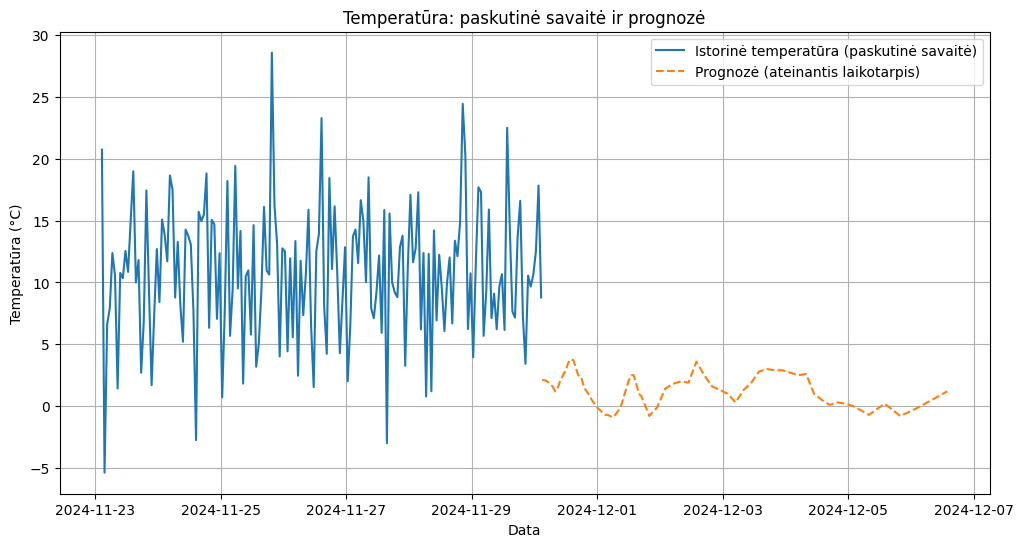

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests


class MeteoClient:
    def __init__(self, location_code, api_url="https://api.meteo.lt/v1/"):
        self.location_code = location_code
        self.api_url = api_url

    def get_forecast_data(self):
        """
        Gauna prognozės duomenis.
        :return: pandas DataFrame su duomenimis ir pd.DatetimeIndex indeksu.
        """
        url = f"{self.api_url}places/{self.location_code}/forecasts/long-term"
        response = requests.get(url)
        response.raise_for_status()

        data = response.json().get("forecastTimestamps", [])
        df = pd.DataFrame(data)
        df['forecastTimeUtc'] = pd.to_datetime(df['forecastTimeUtc'])
        df = df.set_index('forecastTimeUtc')

        return df

    def generate_synthetic_historical_data(self):
        """
        Generuoja sintetinį istorinių duomenų rinkinį vieneriems metams.
        :return: pandas DataFrame su sintetiniais istoriniais duomenimis.
        """
        today = datetime.now()
        start_date = today - timedelta(days=365)

        dates = pd.date_range(start=start_date, end=today, freq='h', tz="Europe/Vilnius")
        temp = np.random.normal(10, 5, len(dates))  # Vidutinė temperatūra su triukšmu
        humidity = np.random.uniform(60, 90, len(dates))  # Drėgmė
        rain = np.random.choice([0, 1], size=len(dates), p=[0.7, 0.3])  # 30% tikimybė, kad lis

        df = pd.DataFrame({
            "temperature": temp,
            "humidity": humidity,
            "rain": rain
        }, index=dates)

        return df


def calculate_metrics(historical_data):
    """
    Atlieka metrikų skaičiavimą.
    """
    # a) Vidutinė metų temperatūra ir drėgmė
    avg_temp = historical_data["temperature"].mean()
    avg_humidity = historical_data["humidity"].mean()

    # b) Vidutinė dienos ir nakties temperatūra
    day_hours = historical_data.between_time("08:00", "20:00")
    night_hours = historical_data.between_time("20:00", "08:00")

    avg_day_temp = day_hours["temperature"].mean()
    avg_night_temp = night_hours["temperature"].mean()

    # c) Kiek savaitgalių lis
    weekend_data = historical_data[historical_data.index.dayofweek >= 5]

    # Pašaliname laiko zonos informaciją, kad išvengtume klaidos
    weekend_data_no_tz = weekend_data.copy()
    weekend_data_no_tz.index = weekend_data_no_tz.index.tz_localize(None)

    rainy_weekends = weekend_data_no_tz.groupby(weekend_data_no_tz.index.to_period("W"))["rain"].sum() > 0
    num_rainy_weekends = rainy_weekends.sum()

    return avg_temp, avg_humidity, avg_day_temp, avg_night_temp, num_rainy_weekends


def interpolate_temperature(temperature_series, freq='5min'):
    """
    Interpoliuoja temperatūros reikšmes iki nurodyto dažnio.
    """
    return temperature_series.resample(freq).interpolate()


def plot_temperature(historical_data, forecast_data):
    """
    Braižo paskutinės savaitės išmatuotą temperatūrą ir ateinančio periodo prognozę.
    """
    # Paskutinės savaitės duomenys
    last_week_start = historical_data.index[-1] - pd.Timedelta(days=7)
    last_week = historical_data.loc[last_week_start:]

    # Konvertuojame prognozės laikus į tą pačią laiko zoną kaip istoriniai duomenys
    forecast_data.index = forecast_data.index.tz_localize("UTC").tz_convert("Europe/Vilnius")

    # Paimame prognozes nuo paskutinės istorinių duomenų datos
    forecast = forecast_data["airTemperature"].loc[last_week.index.max():]

    plt.figure(figsize=(12, 6))
    plt.plot(last_week.index, last_week["temperature"], label="Istorinė temperatūra (paskutinė savaitė)")
    plt.plot(forecast.index, forecast, label="Prognozė (ateinantis laikotarpis)", linestyle="--")
    plt.xlabel("Data")
    plt.ylabel("Temperatūra (°C)")
    plt.title("Temperatūra: paskutinė savaitė ir prognozė")
    plt.legend()
    plt.grid()
    plt.show()


# Pagrindinė programa
if __name__ == "__main__":
    # Inicializacija
    location_code = "vilnius"
    client = MeteoClient(location_code)

    # 1. Istorinių duomenų generavimas ir prognozės gavimas
    historical_data = client.generate_synthetic_historical_data()
    forecast_data = client.get_forecast_data()

    # 2. Metrikų skaičiavimas
    avg_temp, avg_humidity, avg_day_temp, avg_night_temp, num_rainy_weekends = calculate_metrics(historical_data)
    print(f"Vidutinė metų temperatūra: {avg_temp:.2f} °C")
    print(f"Vidutinė metų drėgmė: {avg_humidity:.2f}%")
    print(f"Vidutinė dienos temperatūra: {avg_day_temp:.2f} °C")
    print(f"Vidutinė nakties temperatūra: {avg_night_temp:.2f} °C")
    print(f"Savaitgalių su lietumi: {num_rainy_weekends}")

    # 3. Interpoliuoti temperatūros reikšmes
    interpolated_temp = interpolate_temperature(historical_data["temperature"])
    print(f"Interpoliuotos reikšmės (pirmos 5 eilutės):\n{interpolated_temp.head()}")

    # 4. Paskutinės savaitės temperatūra ir prognozė
    plot_temperature(historical_data, forecast_data)
